## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from sklearn.metrics import (
    accuracy_score,
    adjusted_rand_score,
    f1_score,
    precision_score,
    recall_score,
)

warnings.filterwarnings("ignore")


## Load Test Data

In [4]:
X_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_test.csv"
)
y_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_test.csv"
)["CLASS_encoded"]

## Load Best Clustering Model and Predict on Test Set

In [5]:
model_path = (
    "/home/samir-dahal/Diabetes_Classification/models/clustering/kmeans_model.pkl"
)
with open(model_path, "rb") as f:
    clustering_model = pickle.load(f)

In [ ]:
X_train = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_train_original.csv"
)
y_train = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_train_original.csv"
)["CLASS_encoded"]


In [7]:
train_clusters = clustering_model.predict(X_train)

In [8]:
# Create cluster-to-label mapping
cluster_to_label = {}
for cluster_id in np.unique(train_clusters):
    mask = train_clusters == cluster_id
    most_common_label = pd.Series(y_train[mask]).mode()[0]
    cluster_to_label[cluster_id] = most_common_label

In [9]:
for cluster, label in cluster_to_label.items():
    print(f"  Cluster {cluster} ='{label}'")

  Cluster 0 ='2'
  Cluster 1 ='0'
  Cluster 2 ='2'


In [10]:
test_clusters = clustering_model.predict(X_test)

In [11]:
clustering_predictions = np.array([cluster_to_label[c] for c in test_clusters])


In [12]:
pd.Series(clustering_predictions).value_counts().sort_index()

0     44
2    149
Name: count, dtype: int64

# Loading Xgboost Classifier Model

In [13]:
xg_model_path = (
    "/home/samir-dahal/Diabetes_Classification/models/classification/xgboost.pkl"
)
with open(xg_model_path, "rb") as f:
    xg_model = pickle.load(f)

In [14]:
xg_predictions = xg_model.predict(X_test)


## Calculate comprehensive metrics for both models

In [15]:
# xg_boost metrix
xg_accuracy = accuracy_score(y_test, xg_predictions)
xg_ari = adjusted_rand_score(y_test, xg_predictions)
xg_precision_macro = precision_score(y_test, xg_predictions, average="macro")
xg_recall_macro = recall_score(y_test, xg_predictions, average="macro")
xg_f1_macro = f1_score(y_test, xg_predictions, average="macro")
xg_f1_weighted = f1_score(y_test, xg_predictions, average="weighted")

In [16]:
# clustering metrix k-means
clustering_accuracy = accuracy_score(y_test, clustering_predictions)
clustering_ari = adjusted_rand_score(y_test, clustering_predictions)
clustering_precision_macro = precision_score(
    y_test, clustering_predictions, average="macro"
)
clustering_recall_macro = recall_score(y_test, clustering_predictions, average="macro")
clustering_f1_macro = f1_score(y_test, clustering_predictions, average="macro")
clustering_f1_weighted = f1_score(y_test, clustering_predictions, average="weighted")

In [17]:
# Creating comparison dataframe
metrics_comparison = pd.DataFrame(
    {
        "Metric": [
            "Accuracy",
            "Precision (Macro)",
            "Recall (Macro)",
            "F1-Score (Macro)",
            "F1-Score (Weighted)",
            "ARI",
        ],
        "XGBoost": [
            xg_accuracy,
            xg_precision_macro,
            xg_recall_macro,
            xg_f1_macro,
            xg_f1_weighted,
            xg_ari,
        ],
        "K-Means Clustering": [
            clustering_accuracy,
            clustering_precision_macro,
            clustering_recall_macro,
            clustering_f1_macro,
            clustering_f1_weighted,
            clustering_ari,
        ],
    }
)

# Add difference column
metrics_comparison["Difference"] = (
    metrics_comparison["XGBoost"] - metrics_comparison["K-Means Clustering"]
)

metrics_comparison

,Metric,XGBoost,K-Means Clustering,Difference
0,Accuracy,0.994819,0.870466,0.124352
1,Precision (Macro),0.997967,0.482611,0.515356
2,Recall (Macro),0.966667,0.635992,0.330675
3,F1-Score (Macro),0.981437,0.524573,0.456864
4,F1-Score (Weighted),0.994690,0.866016,0.128675
5,ARI,0.976483,0.628040,0.348443


# Visualization: Overall Metrics Comparison

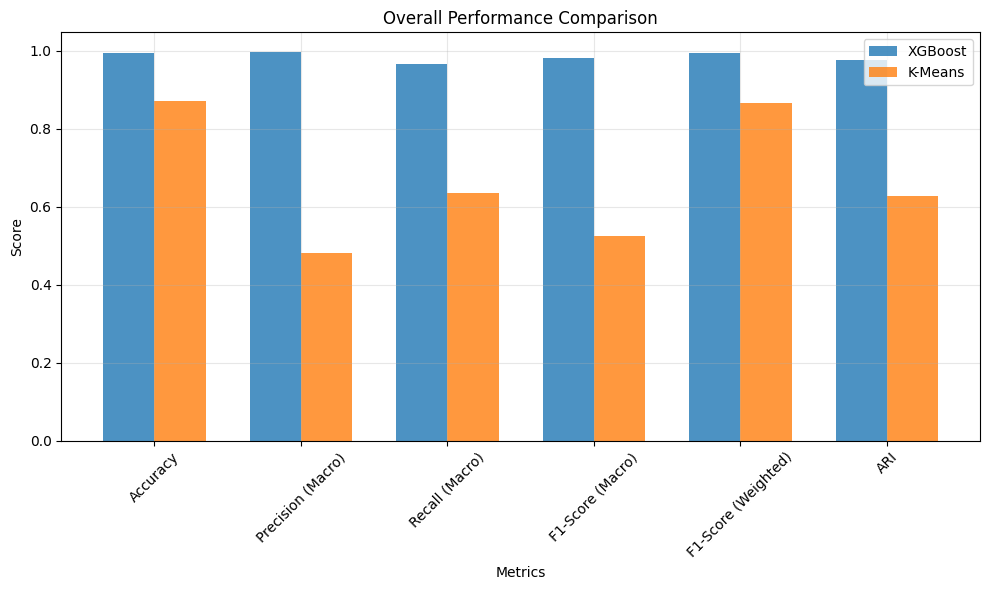

In [18]:
# Overall Metrics Comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x = range(len(metrics_comparison))
width = 0.35

plt.bar(
    [i - width / 2 for i in x],
    metrics_comparison["XGBoost"],
    width,
    label="XGBoost",
    alpha=0.8,
)
plt.bar(
    [i + width / 2 for i in x],
    metrics_comparison["K-Means Clustering"],
    width,
    label="K-Means",
    alpha=0.8,
)

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Overall Performance Comparison")
plt.xticks(x, metrics_comparison["Metric"], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Performance Gap Heatmap

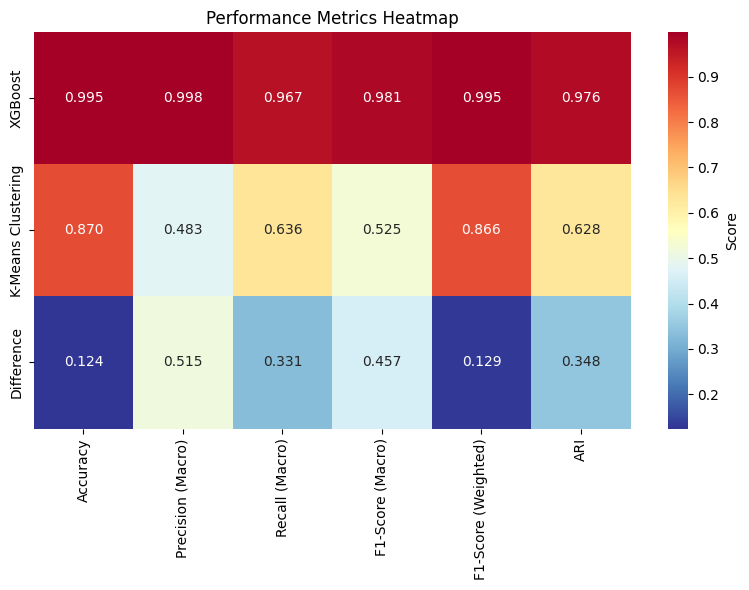

In [19]:
# Performance Gap Heatmap
plt.figure(figsize=(8, 6))
heatmap_data = metrics_comparison[["XGBoost", "K-Means Clustering", "Difference"]].T

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="RdYlBu_r",
    xticklabels=metrics_comparison["Metric"],
    cbar_kws={"label": "Score"},
)
plt.title("Performance Metrics Heatmap")
plt.tight_layout()
plt.show()

# Visualization: Per-Class F1 Scores

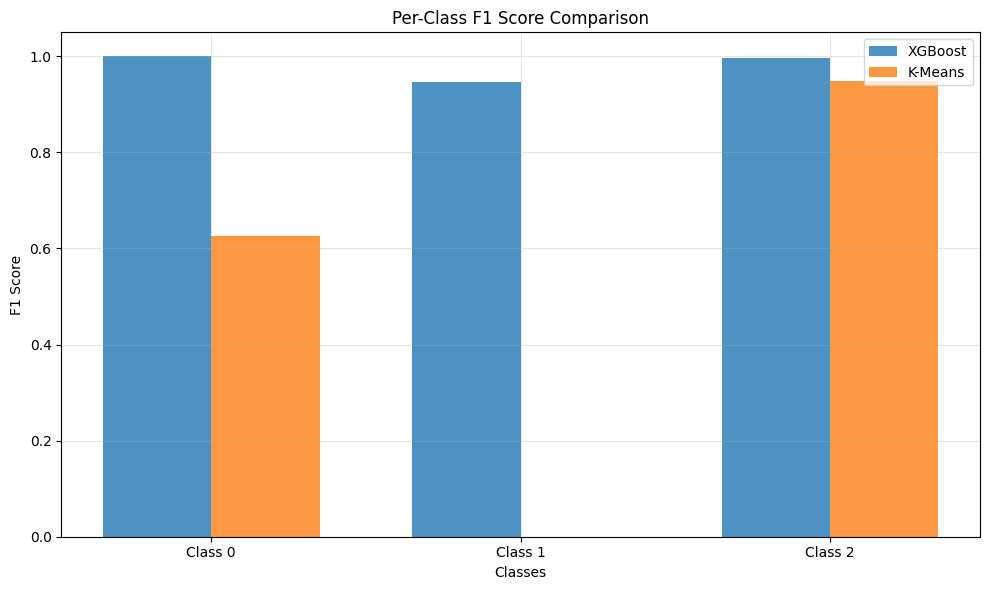

In [20]:
# Per-Class F1 Scores
xg_f1_per_class = f1_score(y_test, xg_predictions, average=None)
clustering_f1_per_class = f1_score(y_test, clustering_predictions, average=None)

classes = ["Class 0", "Class 1", "Class 2"]
x = range(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - width / 2 for i in x], xg_f1_per_class, width, label="XGBoost", alpha=0.8)
plt.bar(
    [i + width / 2 for i in x],
    clustering_f1_per_class,
    width,
    label="K-Means",
    alpha=0.8,
)

plt.xlabel("Classes")
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Score Comparison")
plt.xticks(x, classes)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: F1 Score Breakdown

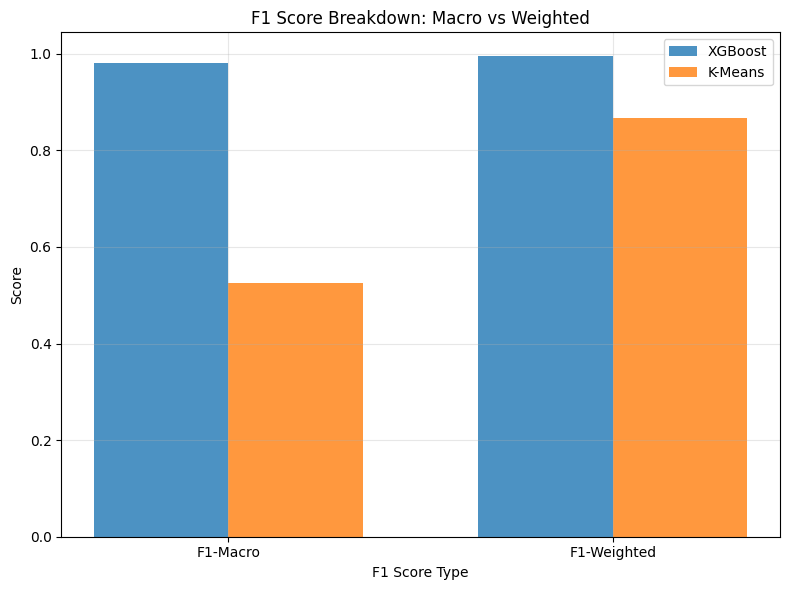

In [22]:
# F1 Score Breakdown (Macro vs Weighted)
f1_types = ["F1-Macro", "F1-Weighted"]
xg_f1_scores = [xg_f1_macro, xg_f1_weighted]
clustering_f1_scores = [clustering_f1_macro, clustering_f1_weighted]

x = range(len(f1_types))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar([i - width / 2 for i in x], xg_f1_scores, width, label="XGBoost", alpha=0.8)
plt.bar(
    [i + width / 2 for i in x], clustering_f1_scores, width, label="K-Means", alpha=0.8
)

plt.xlabel("F1 Score Type")
plt.ylabel("Score")
plt.title("F1 Score Breakdown: Macro vs Weighted")
plt.xticks(x, f1_types)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Accuracy and ARI Comparison

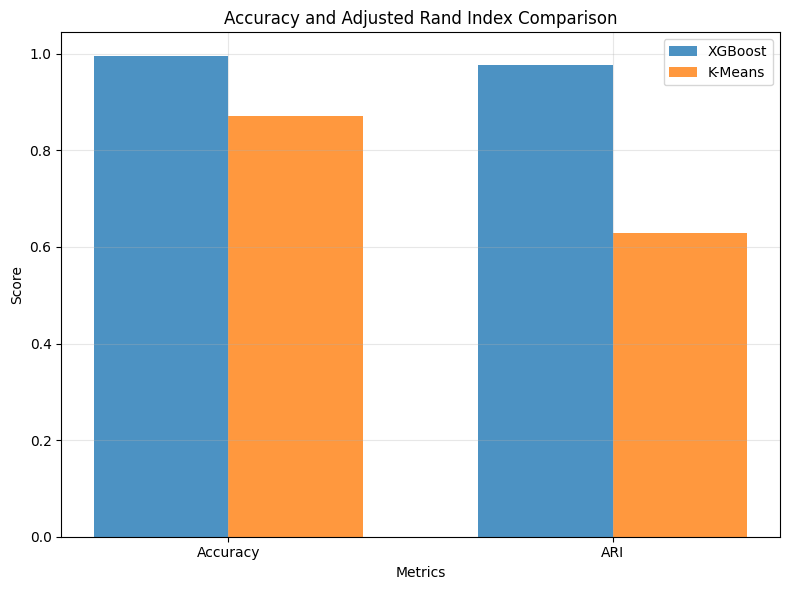

In [23]:
# Accuracy and ARI Comparison
acc_ari_metrics = ["Accuracy", "ARI"]
xg_acc_ari = [xg_accuracy, xg_ari]
clustering_acc_ari = [clustering_accuracy, clustering_ari]

x = range(len(acc_ari_metrics))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar([i - width / 2 for i in x], xg_acc_ari, width, label="XGBoost", alpha=0.8)
plt.bar(
    [i + width / 2 for i in x], clustering_acc_ari, width, label="K-Means", alpha=0.8
)

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Accuracy and Adjusted Rand Index Comparison")
plt.xticks(x, acc_ari_metrics)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Precision vs Recall Scatter Plot

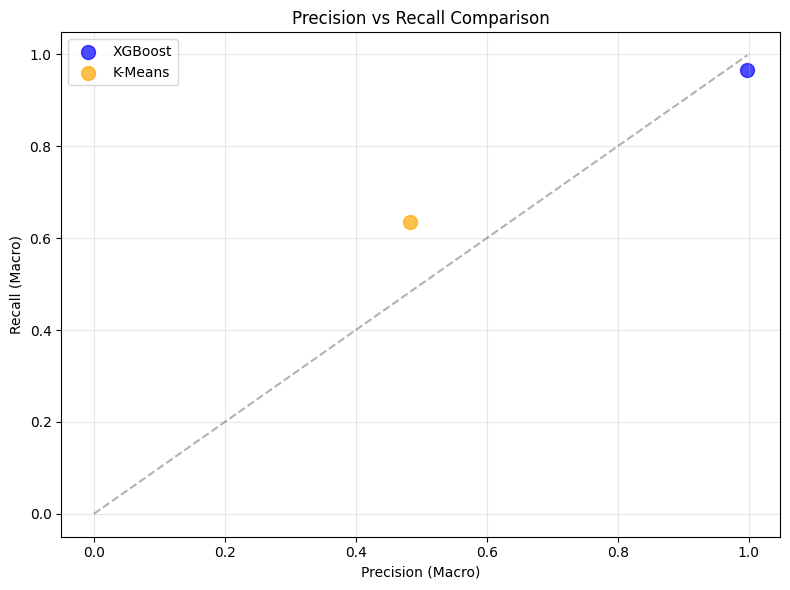

In [24]:
# Precision vs Recall Scatter Plot
plt.figure(figsize=(8, 6))

plt.scatter(
    xg_precision_macro, xg_recall_macro, s=100, alpha=0.7, label="XGBoost", color="blue"
)
plt.scatter(
    clustering_precision_macro,
    clustering_recall_macro,
    s=100,
    alpha=0.7,
    label="K-Means",
    color="orange",
)

plt.xlabel("Precision (Macro)")
plt.ylabel("Recall (Macro)")
plt.title("Precision vs Recall Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

# Add diagonal line for reference
max_val = max(
    max(xg_precision_macro, xg_recall_macro),
    max(clustering_precision_macro, clustering_recall_macro),
)
plt.plot([0, max_val], [0, max_val], "k--", alpha=0.3, label="Perfect Balance")

plt.tight_layout()
plt.show()